In [1]:
import os
import importlib
#from functools import cache

import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.animation as animation
from matplotlib.ticker import LogFormatter
from IPython.display import display

direc = os.getcwd()
os.chdir("/home/b/b381737/python_scripts/master/open_data")
import open_data_utils #import the module here, so that it can be reloaded.
importlib.reload(open_data_utils)
from open_data_utils import xr_to_gdf, add_country_names, country_intersections, select_extent, FlexDataset, FlexDataCollection
os.chdir(direc)


/home/b/b381737/.conda/envs/plot_env/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = SLURMCluster(name='dask-cluster',
                        cores=2,
                        processes=2,
                        n_workers=8,
                        memory='5GB',
                        interface='ib0',
                        queue='prepost',
                        project='bb1170',
                        walltime='01:00:00',
                        asynchronous=0)
client = Client(cluster)
client

/home/b/b381737/.conda/envs/plot_env/lib/python3.10/site-packages/distributed/node.py:181: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33774 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /user/b381737/advanced//proxy/33774/status,
Dashboard: /user/b381737/advanced//proxy/33774/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.50.40.132:38003,Workers: 0
Dashboard: /user/b381737/advanced//proxy/33774/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [16]:
client.shutdown()

In [3]:
dir_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20091123-20091207"
setups = ["wu_setup", "pressure_setup", "pressure_wu_setup", "pressure_wu_fewer_setup", "test_setup", "wu_setup_2", "wu_fewer_setup", "wu_more_setup"]

In [4]:
wu_file = os.path.join(dir_path, setups[0], "grid_time_20091207210000.nc")
pr_file = os.path.join(dir_path, setups[1], "grid_time_20091207210000.nc")
pw_file = os.path.join(dir_path, setups[2], "grid_time_20091207210000.nc")
pwf_file = os.path.join(dir_path, setups[3], "grid_time_20091207210000.nc")
test_file = os.path.join(dir_path, setups[4], "grid_time_20091207210000.nc")
wu_33_file =   "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI_33-60_20091123-20091207/wu/grid_time_20091207210000.nc"
wu2_file = os.path.join(dir_path, setups[5], "grid_time_20091207210000.nc")
wu_few_file = os.path.join(dir_path, setups[6], "grid_time_20091207210000.nc")
wu_more_file = os.path.join(dir_path, setups[7], "grid_time_20091207210000.nc")

In [9]:
#fd = FlexDataset(dir_path + file_path, extent=[100,180,-60,0], chunks=dict(time=15, pointspec=4))
extent = [30,180,-80,0]
chunks = dict(time=15, pointspec=4)
#chunks=None
fd_wu = FlexDataset(wu_file, extent, chunks=chunks, name="Wu Setup", cmaps="Reds", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
fd_pr = FlexDataset(pr_file, extent, chunks=chunks, name="Pressure Setup", cmaps="Blues", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
fd_pw = FlexDataset(pw_file, extent, chunks=chunks, name="Pressure Wu Setup", cmaps="Greens", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
#fd_pwf = FlexDataset(pwf_file, extent, chunks=chunks, name="Pressure Wu (fewer) Setup", cmaps="Purples", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
#fd_test = FlexDataset(test_file, extent, chunks=chunks, name="Test Setup", cmaps="Greens", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
#fd_wu_33 = FlexDataset(wu_33_file, extent, chunks=chunks, name="Wu Setup 33-60", cmaps="Greens", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
#fd_wu2 = FlexDataset(wu2_file, extent, chunks=chunks, name="Wu Setup 2", cmaps="Greens", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
#fd_wu_few = FlexDataset(wu_few_file, extent, chunks=chunks, name="Wu (less particles)", cmaps="Reds", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])
#fd_wu_more = FlexDataset(wu_more_file, extent, chunks=chunks, name="Wu (more particles)", cmaps="Greens", norm=colors.LogNorm(), station_names=["Darwin", "Wollongong"])

Loaded Footprints from /work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20091123-20091207/wu_setup
Loaded Footprints from /work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20091123-20091207/pressure_setup
Loaded Footprints from /work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20091123-20091207/pressure_wu_setup


<GeoAxesSubplot:title={'center':'height = 100.0 [meters]'}, xlabel='longitude in degree east\n[degrees_east]', ylabel='latitude in degree north\n[degrees_north]'>

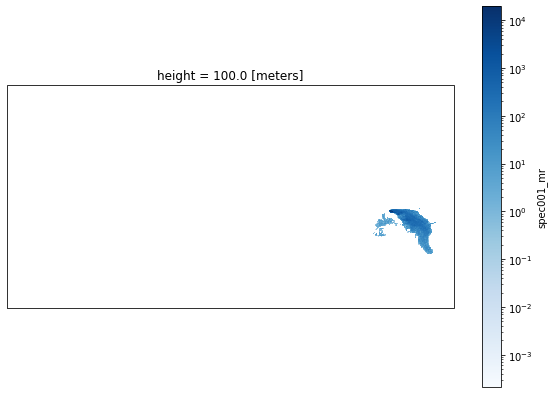

In [10]:
fig, ax = fd_pr.subplots(figsize=(10,7))
fd_pr.plot(ax, 0, np.arange(99), np.arange(36))

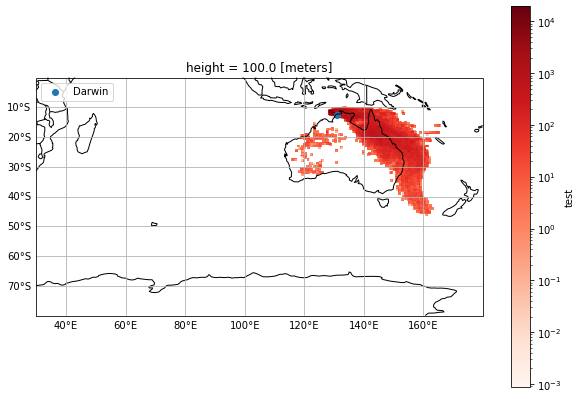

In [25]:
fig, ax = fd_wu.subplots(figsize=(10,7))
fd_wu.plot_footprint(ax, station=0, plot_station=True, station_kwargs=dict(label=fd_wu.station_names[0]), cbar_kwargs=dict(label="test"))
fd_wu.add_map(ax)
plt.legend(loc="upper left")

(<GeoAxesSubplot:title={'center':'height = 100.0 [meters]'}, xlabel='longitude in degree east\n[degrees_east]', ylabel='latitude in degree north\n[degrees_north]'>,
 <cartopy.mpl.gridliner.Gridliner at 0x2ac4cc49f010>)

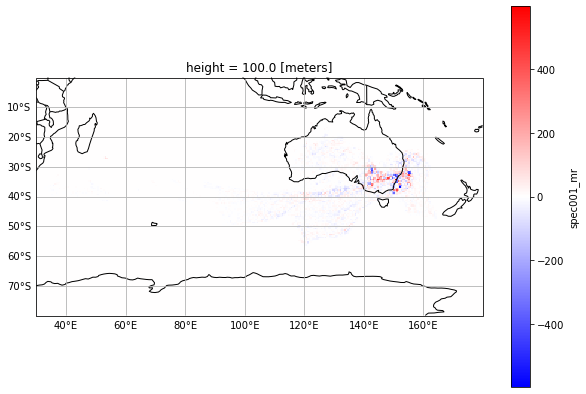

In [10]:
fp1 = fd_wu
fp2 = fd_pw
diff = fp2.Footprints[1]-fp1.Footprints[1]
fig, ax = fd_wu.subplots(figsize=(10,7))
diff.plot(ax=ax,cmap="bwr")
fd_wu.add_map(ax =ax)

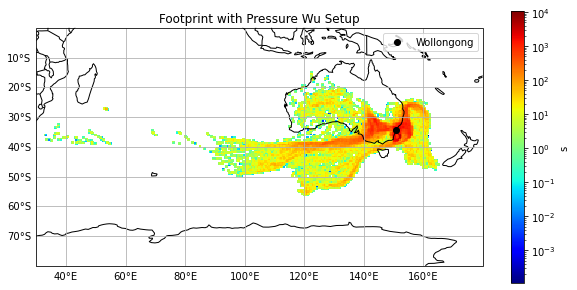

In [23]:
fd = fd_pw
station = 1
fig, ax = fd.subplots(figsize=(10,5))
fd.plot_footprint(ax, station , plot_station=True,cmap="jet",station_kwargs=dict(color="black", label=fd.station_names[station]), cbar_kwargs=dict(label="s"))
fd.add_map(ax)
ax.set_title(f"Footprint with {fd.name}")
plt.legend(loc="upper right")
plt.savefig("figures/australia/column_setups/pressure_wu_setup.png", dpi=300)

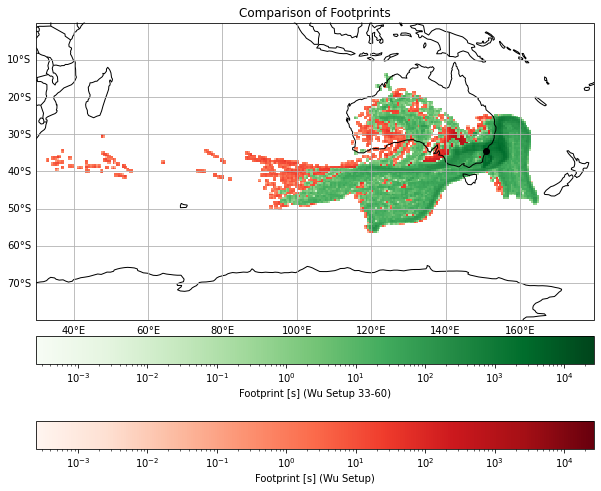

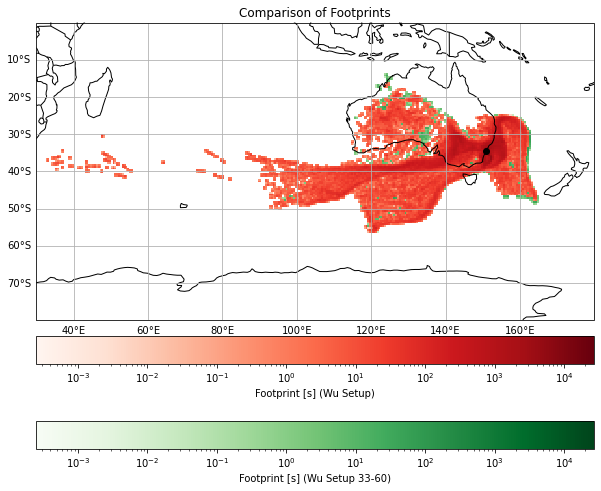

In [34]:
fds = [fd_wu, fd_wu_33]

vmin = 1
vmax = 0
for i,fd in enumerate(fds):
    vmin = fd.vmin() if fd.vmin()<vmin else vmin
    vmax = fd.vmax() if fd.vmax()>vmax else vmax

station = 1
setup = ["Wu", "Pressure Wu"]

for i,fd in enumerate(fds):
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree())) if i == 0 else (fig,ax)
    fd.plot_footprint(ax, station, plot_station=True, vmin=vmin, vmax=vmax, cbar_kwargs=dict(label=f"Footprint [s] ({fd.name})", orientation="horizontal", pad=0.035))
    fd.add_map(ax) if i == 0 else None
    ax.set_title("Comparison of Footprints")
plt.savefig("figures/australia/column_setups/33_vs_normal.png", dpi=300)
plt.show()


fds.reverse()
for i,fd in enumerate(fds):
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree())) if i == 0 else (fig,ax)
    fd.plot_footprint(ax, station, plot_station=True, vmin=vmin, vmax=vmax, cbar_kwargs=dict(label=f"Footprint [s] ({fd.name})", orientation="horizontal", pad=0.035))
    fd.add_map(ax) if i == 0 else None
    ax.set_title("Comparison of Footprints")
plt.show()

In [163]:
fds.reverse()

In [185]:
fds = [fd_wu, fd_pr, fd_pw, fd_pwf, fd_test, fd_wu_33]
station = 0
for ind in range(len(fds)):
    inds = np.delete(np.arange(len(fds)), ind)

    columns =["Setup","Footprint sum", f"Total difference to {fds[ind].name}", f"Relative difference to {fds[ind].name}"]
    df = pd.DataFrame(columns=columns)
    comp_fd = fds[ind]
    comp_vals = comp_fd.Footprints[station].values
    for j, i in enumerate(inds):
        fd = fds[i]
        vals = fd.Footprints[station].values
        line = [fd.name, vals.sum(), np.sum(np.abs(comp_vals-vals)), np.sum(np.abs(comp_vals-vals))/comp_vals.sum()]
        #line = dict(zip(columns,line))
        df.loc[len(df)] = line
        #df = df.merge(pd.DataFrame(line))
    display(df)

,Setup,Footprint sum,Total difference to Wu Setup,Relative difference to Wu Setup
0,Pressure Setup,471690.65625,96368.726562,0.199047
1,Pressure Wu Setup,481622.00000,99343.718750,0.205192
2,Pressure Wu (fewer) Setup,475259.96875,101112.585938,0.208846
3,Test Setup,58592.25000,425898.656250,0.879684
4,Wu Setup 33-60,626357.62500,502795.687500,1.038513
5,Wu Setup 2,484149.81250,0.000000,0.000000


,Setup,Footprint sum,Total difference to Pressure Setup,Relative difference to Pressure Setup
0,Wu Setup,484149.81250,96368.726562,0.204305
1,Pressure Wu Setup,481622.00000,91171.226562,0.193286
2,Pressure Wu (fewer) Setup,475259.96875,96575.835938,0.204744
3,Test Setup,58592.25000,413277.968750,0.876163
4,Wu Setup 33-60,626357.62500,499529.093750,1.059018
5,Wu Setup 2,484149.81250,96368.726562,0.204305


,Setup,Footprint sum,Total difference to Pressure Wu Setup,Relative difference to Pressure Wu Setup
0,Wu Setup,484149.81250,99343.718750,0.206269
1,Pressure Setup,471690.65625,91171.226562,0.189300
2,Pressure Wu (fewer) Setup,475259.96875,91347.742188,0.189667
3,Test Setup,58592.25000,423460.218750,0.879238
4,Wu Setup 33-60,626357.62500,491106.968750,1.019694
5,Wu Setup 2,484149.81250,99343.718750,0.206269


,Setup,Footprint sum,Total difference to Pressure Wu (fewer) Setup,Relative difference to Pressure Wu (fewer) Setup
0,Wu Setup,484149.81250,101112.585938,0.212752
1,Pressure Setup,471690.65625,96575.835938,0.203206
2,Pressure Wu Setup,481622.00000,91347.742188,0.192206
3,Test Setup,58592.25000,417085.812500,0.877595
4,Wu Setup 33-60,626357.62500,493503.468750,1.038386
5,Wu Setup 2,484149.81250,101112.585938,0.212752


,Setup,Footprint sum,Total difference to Test Setup,Relative difference to Test Setup
0,Wu Setup,484149.81250,425898.65625,7.268857
1,Pressure Setup,471690.65625,413277.96875,7.053458
2,Pressure Wu Setup,481622.00000,423460.21875,7.227240
3,Pressure Wu (fewer) Setup,475259.96875,417085.81250,7.118447
4,Wu Setup 33-60,626357.62500,571691.25000,9.757113
5,Wu Setup 2,484149.81250,425898.65625,7.268857


,Setup,Footprint sum,Total difference to Wu Setup 33-60,Relative difference to Wu Setup 33-60
0,Wu Setup,484149.81250,502795.68750,0.802729
1,Pressure Setup,471690.65625,499529.09375,0.797514
2,Pressure Wu Setup,481622.00000,491106.96875,0.784068
3,Pressure Wu (fewer) Setup,475259.96875,493503.46875,0.787894
4,Test Setup,58592.25000,571691.25000,0.912723
5,Wu Setup 2,484149.81250,502795.68750,0.802729


,Setup,Footprint sum,Total difference to Wu Setup 2,Relative difference to Wu Setup 2
0,Wu Setup,484149.81250,0.000000,0.000000
1,Pressure Setup,471690.65625,96368.726562,0.199047
2,Pressure Wu Setup,481622.00000,99343.718750,0.205192
3,Pressure Wu (fewer) Setup,475259.96875,101112.585938,0.208846
4,Test Setup,58592.25000,425898.656250,0.879684
5,Wu Setup 33-60,626357.62500,502795.687500,1.038513


In [35]:
fds = [fd_wu, fd_wu_33, fd_pr, fd_pw]
station = 0
for ind in range(len(fds)):
    inds = np.delete(np.arange(len(fds)), ind)

    columns =["Setup","Footprint sum", f"Total difference to {fds[ind].name}", f"Relative difference to {fds[ind].name}"]
    df = pd.DataFrame(columns=columns)
    comp_fd = fds[ind]
    comp_vals = comp_fd.Footprints[station].values
    for j, i in enumerate(inds):
        fd = fds[i]
        vals = fd.Footprints[station].values
        line = [fd.name, vals.sum(), np.sum(np.abs(comp_vals-vals)), np.sum(np.abs(comp_vals-vals))/comp_vals.sum()]
        #line = dict(zip(columns,line))
        df.loc[len(df)] = line
        #df = df.merge(pd.DataFrame(line))
    display(df)

,Setup,Footprint sum,Total difference to Wu Setup,Relative difference to Wu Setup
0,Wu Setup 33-60,626357.62500,502795.687500,1.038513
1,Pressure Setup,471690.65625,96368.726562,0.199047
2,Pressure Wu Setup,481622.00000,99343.718750,0.205192


,Setup,Footprint sum,Total difference to Wu Setup 33-60,Relative difference to Wu Setup 33-60
0,Wu Setup,484149.81250,502795.68750,0.802729
1,Pressure Setup,471690.65625,499529.09375,0.797514
2,Pressure Wu Setup,481622.00000,491106.96875,0.784068


,Setup,Footprint sum,Total difference to Pressure Setup,Relative difference to Pressure Setup
0,Wu Setup,484149.8125,96368.726562,0.204305
1,Wu Setup 33-60,626357.6250,499529.093750,1.059018
2,Pressure Wu Setup,481622.0000,91171.226562,0.193286


,Setup,Footprint sum,Total difference to Pressure Wu Setup,Relative difference to Pressure Wu Setup
0,Wu Setup,484149.81250,99343.718750,0.206269
1,Wu Setup 33-60,626357.62500,491106.968750,1.019694
2,Pressure Setup,471690.65625,91171.226562,0.189300


# Assign Country to data and choose

In [34]:
mass = data.spec001_mr[dict(pointspec=[0,1,2])].sum(dim=["time", "pointspec"])[0]
gdf = xr_to_gdf(mass, "spec001_mr")
gdf = add_country_names(gdf)
#gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf.pkl")
ci = country_inersections(gdf, "Australia")
#intersections = country_inersections(mass, "Australia")

In [35]:
gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf_woll_12.pkl")

In [95]:
columns=["Station","Year","Total [s]", "Australia [%]", "Other countries [%]", "Ocean [%]"]
df = pd.DataFrame(columns=columns)
direc="/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/"
l = []
for y in ["09", "12"]:
    for stat in ["woll", "dar"]:
    
        l.append("Wollongong" if stat == "woll" else "Darwin")
        l.append("20"+y)
        path = f"gdf_{stat}_{y}.pkl"
        print(path)
        gdf = pd.read_pickle(direc+path)
        ret = country_intersections(gdf, "Australia")
        tot = gdf.spec001_mr.sum()
        l.append(round(tot, 0))
        for key in ret.keys():
            if key == "rest":
                continue
            l.append(round(ret[key].spec001_mr.sum()/tot*100, 2))
        df = df.append(dict(zip(columns,l)), ignore_index=True)
        l = []

gdf_woll_09.pkl
gdf_dar_09.pkl
gdf_woll_12.pkl
gdf_dar_12.pkl


# Animation

In [ ]:
#for vmin
mass = data.spec001_mr.where(data.spec001_mr!=0)
#height index, vmin, vmax for cbar
h_ind = 0
vmin = np.min(mass.isel(pointspec=[0])).values
vmax = np.max(mass.isel(pointspec=[0])).values
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[0,180,-85,-0]

cmap = "jet"
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    mass = data.spec001_mr.isel(time=[ind], height=[h_ind], pointspec=[0])
    mass = mass.where(mass!=0)
    if len(fig.axes)==1:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(), 
                  cbar_kwargs=dict(label="Footprint [s]"))
    else:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(),
                  add_colorbar=False)
    ax.set_title(data.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/master/open_data/animations/australia/wu.gif")

# Compare two datasets

1914299000.0
3.5516213e+18


/home/b/b381737/.conda/envs/plot_env/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


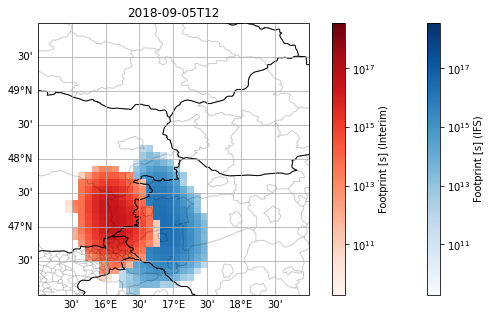

In [26]:
#for vmin
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/OD20180905/grid_conc_20180905000000.nc"
data1 = xr.open_dataset(file_path)
mass1 = data1.spec001_mr
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180905/grid_conc_20180905000000.nc"
data2 = xr.open_dataset(file_path)
mass2 = data2.spec001_mr
mass2 = select_extent(mass2, 5, 25, 40, 55)

mass1 = mass1.where(mass1!=0)
mass2 = mass2.where(mass2!=0)



#height index, vmin, vmax for cbar
h_ind = 0
vmin = min([np.min(mass1.isel(pointspec=[0])).values, np.min(mass2.isel(pointspec=[0])).values])
vmax = max([np.max(mass1.isel(pointspec=[0])).values, np.max(mass2.isel(pointspec=[0])).values])
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[15, 19, 46, 50]

cmaps = ["Blues", "Reds"]
labels = ["Footprint [s] (IFS)", "Footprint [s] (Interim)"]#["Footprint [s] (Interim)", "Footprint [s] (IFS)"]
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data1.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    #ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    for i, mass in enumerate([mass1,mass2]):
        mass = mass.isel(dict(time=ind, height=0))
        mass = mass.where(mass!=0)
        if len(fig.axes)==(i+1):
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(), 
                      cbar_kwargs=dict(label=labels[i]))
        else:
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False)
    ax.set_title(data1.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/master/open_data/animations/tutorial/vienna_comparision2.gif")